# Import python library

In [1]:
import os, shutil
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io, signal
from scipy.fftpack import fft, fftshift

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

print("Installed tensorflow version: ", tf.__version__)

Installed tensorflow version:  2.7.0


# GPU setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # GPU unit setting
tf.keras.backend.floatx()

'float32'

# Parameters Setting for training

In [3]:
### data parameters
winT = 18000 # one priod


### RMSprop optimizer parameters
lr_begin = 1e-3
RHO = 0.8

### Training parameters 
MAX_EPOCHS = 80
BATCH_SIZE = 128
EPOCH_1 = math.ceil(MAX_EPOCHS/2)
EPOCH_2 = math.ceil(MAX_EPOCHS*3/4)

# Load measured datasets

In [4]:
print("[Info.] where am I?")
%pwd

[Info.] where am I?


'/home/wkchoi/Arc-Fault'

In [5]:
# Define signal plot function
def show_signal_subplot(n_show, data, label, YRNG_MIN=-1, YRNG_MAX=1):
    plt.figure(2, figsize=(12, 8))
    plt.subplots_adjust(wspace=0.5)
    for i in range(n_show):
        plt.subplot(5, 10, i + 1)
        plt.plot(data[i], color='cornflowerblue')
        plt.text(int(data.shape[1]/2), 0, "%d" % label[i], fontsize=12, color='r')
        plt.xlim(0, data.shape[1])
        plt.ylim(YRNG_MIN, YRNG_MAX)
        
def data_shuffle(data):
    s = np.arange(data.shape[0])
    np.random.shuffle(s)
    
    return data[s]
    
    

def gen_one_period_data(file_path, winT):
    
    ##### load raw data
    data_raw = pd.read_excel(file_path, index_col=None, header=None, sheet_name='Sheet1')
    data = data_raw.to_numpy() # numpy array
    
    ##### Data Normalization
    data_n = np.zeros((data.shape[0],data.shape[1]))
    for i in range(data.shape[1]):
        data_n[:,i] = data[:,i]/max(abs(data[:,i]))  
    
    ##### expand one-period dataset
    dT = round(winT / 10)
    Num = round((data_n.shape[0] - winT)/dT)
    
    data_tot = np.zeros((winT,Num*data_n.shape[1]))
    index = 0
    for i in range(data_n.shape[1]):
        for j in range(Num):
            index = Num*i+j
            data_tot[:,index] = data_n[j*dT:winT+j*dT,i]
            
    print("[Info.] Total re-arranged one-period data shape: ", data_tot.shape)
    
    return data_tot

def merge_one_period_data(winT, *file_paths):
    
    subArrays = []
    for file_path in file_paths:
        data = gen_one_period_data(file_path, winT)
        subArrays.append(data)
                
    allArrays = np.concatenate(subArrays, axis=1)
    
    print("[Info.] ==========> Total merged one-period data shape: ", allArrays.shape, "\n")
        
    return allArrays

In [6]:
base_dir = "/home/wkchoi/Arc-Fault"

## 1. Fan dataset

In [7]:
### Fan arc raw dataset
file_path1 = os.path.join(base_dir, "Fan/arc/Fan_1_arc_humid_44(c61)_data.xlsx")
file_path2 = os.path.join(base_dir, "Fan/arc/Fan_2_arc_humid_45_data.xlsx")
file_path3 = os.path.join(base_dir, "Fan/arc/Fan_1_arc_humid_34(c14)_c2_data.xlsx")
file_path4 = os.path.join(base_dir, "Fan/arc/Fan_2_arc_humid_34(c23)_c15_data.xlsx")
file_path5 = os.path.join(base_dir, "Fan/arc/fan_1_arc_data.xlsx")
file_path6 = os.path.join(base_dir, "Fan/arc/fan_2_arc(c57)_data.xlsx")
file_paths = [file_path1, file_path2, file_path3, file_path4, file_path5, file_path6]
fan_arc = merge_one_period_data(winT, *file_paths)

##### Fan normal raw dataset
file_path1 = os.path.join(base_dir, "Fan/normal/Fan_1_normal_humid_room_data.xlsx")
file_path2 = os.path.join(base_dir, "Fan/normal/Fan_2_normal_humid_50_data.xlsx")
file_path3 = os.path.join(base_dir, "Fan/normal/fan_1_normal_data.xlsx")
file_path4 = os.path.join(base_dir, "Fan/normal/fan_2_normal(c54)_data.xlsx")
file_paths = [file_path1, file_path2, file_path3, file_path4]
fan_normal = merge_one_period_data(winT, *file_paths)

#### Fan Data shuffle
fan_arc_1 = data_shuffle(fan_arc.T)
fan_arc_2 = fan_arc_1.T[:,:]

fan_normal_1 = data_shuffle(fan_normal.T)
fan_normal_2 = fan_normal_1.T[:,:]

[Info.] Total re-arranged one-period data shape:  (18000, 1480)
[Info.] Total re-arranged one-period data shape:  (18000, 1560)
[Info.] Total re-arranged one-period data shape:  (18000, 80)
[Info.] Total re-arranged one-period data shape:  (18000, 600)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 1880)
[Info.] ==========> Total merged one-period data shape:  (18000, 7600) 

[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 2160)
[Info.] ==========> Total merged one-period data shape:  (18000, 8160) 



## 2. Fluor dataset

In [8]:
### Fluor arc raw dataset
file_path1 = os.path.join(base_dir, "Fluor/arc/Fluor_1_arc_humid_40(c79)_data.xlsx")
file_path2 = os.path.join(base_dir, "Fluor/arc/Fluor_1_arc_humid_50(weird)_data.xlsx")
file_path3 = os.path.join(base_dir, "Fluor/arc/Fluor_2_arc_humid_40(c65)_data.xlsx")
file_path4 = os.path.join(base_dir, "Fluor/arc/Fluor_2_arc_humid_23(c51)_data(c45).xlsx")
file_paths = [file_path1, file_path2, file_path3, file_path4]
fluor_arc = merge_one_period_data(winT, *file_paths)

##### Fluor normal raw dataset
file_path1 = os.path.join(base_dir, "Fluor/normal/Fluor_1_normal_humid_room_data.xlsx")
file_path2 = os.path.join(base_dir, "Fluor/normal/Fluor_2_normal_humid_34_data.xlsx")
file_path3 = os.path.join(base_dir, "Fluor/normal/Fluor_2_normal(c37)_data.xlsx")
file_paths = [file_path1, file_path2, file_path3]
fluor_normal = merge_one_period_data(winT, *file_paths)

#### Fluor Data shuffle
fluor_arc_1 = data_shuffle(fluor_arc.T)
fluor_arc_2 = fluor_arc_1.T[:,:]

fluor_normal_1 = data_shuffle(fluor_normal.T)
fluor_normal_2 = fluor_normal_1.T[:,:]

[Info.] Total re-arranged one-period data shape:  (18000, 3160)
[Info.] Total re-arranged one-period data shape:  (18000, 360)
[Info.] Total re-arranged one-period data shape:  (18000, 2600)
[Info.] Total re-arranged one-period data shape:  (18000, 1800)
[Info.] ==========> Total merged one-period data shape:  (18000, 7920) 

[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 1480)
[Info.] ==========> Total merged one-period data shape:  (18000, 5480) 



## 3. Heat dataset


In [9]:
### Heat arc raw dataset
file_path1 = os.path.join(base_dir, "Heat/arc/Heat_1_arc_humid_40(c56)_data.xlsx")
file_path2 = os.path.join(base_dir, "Heat/arc/Heat_1_arc_humid_50_data.xlsx")
file_path3 = os.path.join(base_dir, "Heat/arc/Heat_2_arc_humid_40_data.xlsx")
file_path4 = os.path.join(base_dir, "Heat/arc/Heater_2_arc_humid_34(c27)_data.xlsx")
file_paths = [file_path1, file_path2, file_path3, file_path4]
heat_arc = merge_one_period_data(winT, *file_paths)

##### Heat normal raw dataset
file_path1 = os.path.join(base_dir, "Heat/normal/Heat_1_normal_humid_room_data.xlsx")
file_path2 = os.path.join(base_dir, "Heat/normal/Heat_2_normal_humid_40_data.xlsx")
file_paths = [file_path1, file_path2]
heat_normal = merge_one_period_data(winT, *file_paths)

### Heat Data Shuffle
heat_arc_1 = data_shuffle(heat_arc.T)
heat_arc_2 = heat_arc_1.T[:,:]

heat_normal_1 = data_shuffle(heat_normal.T)
heat_normal_2 = heat_normal_1.T[:,:]

[Info.] Total re-arranged one-period data shape:  (18000, 2240)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 1080)
[Info.] ==========> Total merged one-period data shape:  (18000, 7320) 

[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] ==========> Total merged one-period data shape:  (18000, 4000) 



## 4. Incan dataset

In [10]:
### Incan arc raw dataset
file_path1 = os.path.join(base_dir, "incan/arc/incan_1_arc_humid_room_data.xlsx")
file_path2 = os.path.join(base_dir, "incan/arc/incan_2_arc_44_data.xlsx")
file_path3 = os.path.join(base_dir, "incan/arc/Incan_2_arc_humid_40(c60)_data.xlsx")
file_path4 = os.path.join(base_dir, "incan/arc/Incan_2_arc_humid_40(c61-c120)_data.xlsx")
file_path5 = os.path.join(base_dir, "incan/arc/Incan_2_arc_humid_40(c121-c161)_data.xlsx")
file_path6 = os.path.join(base_dir, "incan/arc/Incan_2_arc_humid_95(c60)_data.xlsx")
file_path7 = os.path.join(base_dir, "incan/arc/Incan_2_arc_humid_95(c61-c82)_data.xlsx")
file_path8 = os.path.join(base_dir, "incan/arc/Incan_2_arc_humid_room(after humid95)(c53)_data.xlsx")
file_paths = [file_path1, file_path2, file_path3, file_path4, file_path5, file_path6,
             file_path7, file_path8]
incan_arc = merge_one_period_data(winT, *file_paths)

##### Incan normal raw dataset
file_path1 = os.path.join(base_dir, "incan/normal/incan_1_normal_humid_room_data.xlsx")
file_path2 = os.path.join(base_dir, "incan/normal/incan_2_normal_humid_room_data.xlsx")
file_paths = [file_path1, file_path2]
incan_normal = merge_one_period_data(winT, *file_paths)

### Incan Data Shuffle
incan_arc_1 = data_shuffle(incan_arc.T)
incan_arc_2 = incan_arc_1.T[:,:]

incan_normal_1 = data_shuffle(incan_normal.T)
incan_normal_2 = incan_normal_1.T[:,:]

[Info.] Total re-arranged one-period data shape:  (18000, 1880)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 2400)
[Info.] Total re-arranged one-period data shape:  (18000, 2400)
[Info.] Total re-arranged one-period data shape:  (18000, 1640)
[Info.] Total re-arranged one-period data shape:  (18000, 2400)
[Info.] Total re-arranged one-period data shape:  (18000, 880)
[Info.] Total re-arranged one-period data shape:  (18000, 2120)
[Info.] ==========> Total merged one-period data shape:  (18000, 15720) 

[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] ==========> Total merged one-period data shape:  (18000, 4000) 



## 5. Led dataset

In [11]:
### LED arc raw dataset
file_path1 = os.path.join(base_dir, "Led/arc/led_1_arc_humid_23_c(30)_data(c29).xlsx")
file_path2 = os.path.join(base_dir, "Led/arc/LED_1_arc(c19)_data.xlsx")
file_path3 = os.path.join(base_dir, "Led/arc/LED_2_arc(c34)_data.xlsx")
file_path4 = os.path.join(base_dir, "Led/arc/led_1_arc(c43)_data.xlsx")
file_path5 = os.path.join(base_dir, "Led/arc/led_1_arc(c50)_data.xlsx")
file_path6 = os.path.join(base_dir, "Led/arc/led_2_arc(c56)_data.xlsx")
file_paths = [file_path1, file_path2, file_path3, file_path4, file_path5, file_path6]
led_arc = merge_one_period_data(winT, *file_paths)

##### LED normal raw dataset
file_path1 = os.path.join(base_dir, "Led/normal/led_1_normal_c(36)_data.xlsx")
file_path2 = os.path.join(base_dir, "Led/normal/led_1_normal_humid_room_data.xlsx")
file_path3 = os.path.join(base_dir, "Led/normal/led_2_normal_c(32)_data.xlsx")
file_path4 = os.path.join(base_dir, "Led/normal/LED_2_normal(c40)_data.xlsx")
file_path5 = os.path.join(base_dir, "Led/normal/led_1_normal(c3)_data.xlsx")
file_paths = [file_path1, file_path2, file_path3, file_path4, file_path5]
led_normal = merge_one_period_data(winT, *file_paths)

### LED Data Shuffle
led_arc_1 = data_shuffle(led_arc.T)
led_arc_2 = led_arc_1.T[:,:]

led_normal_1 = data_shuffle(led_normal.T)
led_normal_2 = led_normal_1.T[:,:]

[Info.] Total re-arranged one-period data shape:  (18000, 1160)
[Info.] Total re-arranged one-period data shape:  (18000, 760)
[Info.] Total re-arranged one-period data shape:  (18000, 1360)
[Info.] Total re-arranged one-period data shape:  (18000, 1600)
[Info.] Total re-arranged one-period data shape:  (18000, 1800)
[Info.] Total re-arranged one-period data shape:  (18000, 1920)
[Info.] ==========> Total merged one-period data shape:  (18000, 8600) 

[Info.] Total re-arranged one-period data shape:  (18000, 1440)
[Info.] Total re-arranged one-period data shape:  (18000, 2000)
[Info.] Total re-arranged one-period data shape:  (18000, 1280)
[Info.] Total re-arranged one-period data shape:  (18000, 1600)
[Info.] Total re-arranged one-period data shape:  (18000, 120)
[Info.] ==========> Total merged one-period data shape:  (18000, 6440) 



In [12]:
# 데이터 불균형으로 데이터를 자름 (oversampling 또는 다른 방법 필요)
print('------Fan------')
print(fan_arc_2.shape)
print(fan_normal_2.shape)
fan_normal_2 = fan_normal_1.T[:,:7600]
print(fan_arc_2.shape)
print(fan_normal_2.shape)

print('------Fluor------')
print(fluor_arc_2.shape)
print(fluor_normal_2.shape)
fluor_arc_2 = fluor_arc_1.T[:,:5480]
print(fluor_arc_2.shape)
print(fluor_normal_2.shape)

print('------Heat------')
print(heat_arc_2.shape)
print(heat_normal_2.shape)
heat_arc_2 = heat_arc_1.T[:,:4000]
print(heat_arc_2.shape)
print(heat_normal_2.shape)

print('------Incan------')
print(incan_arc_2.shape)
print(incan_normal_2.shape)
incan_arc_2 = incan_arc_1.T[:,:4000]
print(incan_arc_2.shape)
print(incan_normal_2.shape)

print('------Led------')
print(led_arc_2.shape)
print(led_normal_2.shape)
led_arc_2 = led_arc_1.T[:,:6440]
print(led_arc_2.shape)
print(led_normal_2.shape)

------Fan------
(18000, 7600)
(18000, 8160)
(18000, 7600)
(18000, 7600)
------Fluor------
(18000, 7920)
(18000, 5480)
(18000, 5480)
(18000, 5480)
------Heat------
(18000, 7320)
(18000, 4000)
(18000, 4000)
(18000, 4000)
------Incan------
(18000, 15720)
(18000, 4000)
(18000, 4000)
(18000, 4000)
------Led------
(18000, 8600)
(18000, 6440)
(18000, 6440)
(18000, 6440)


# Feature Extraction

In [13]:
# 특성추출을 위한 함수 작성 ( 변수이름, 데이터 크기)
def create_feature(x, y):
    feature = np.zeros(shape=(39,y))
    mean_val = np.zeros((10, y))
    std_val = np.zeros((10, y))
    Pole_diff = np.zeros((10, y))
    Avg_diff = np.zeros((9, y))

    for i in range(y):
        sig = x[:, i]
        win = round(x.shape[0]/10)
        for j in range(10):
            tmp = x[int(j * win) : int((j + 1) * win)]
            mean_val[j] = np.mean(tmp[j],axis=0)
            std_val[j] = np.std(tmp[j])
            Pole_diff[j] = np.max(tmp[j]) - np.min(tmp[j])
        for z in range(9):
            Avg_diff[z] = np.mean(tmp[z], axis=0) - np.mean(tmp[z+1],axis=0)
        
    feature = np.concatenate((mean_val, std_val, Pole_diff, Avg_diff), axis =0)
    return feature

In [14]:
# 5종류 Arc / Normal 특성추출
fan_arc = create_feature(fan_arc_2, 7600)
fan_normal = create_feature(fan_normal_2, 7600)
fluor_arc = create_feature(fluor_arc_2, 5480)
fluor_normal = create_feature(fluor_normal_2, 5480)
heat_arc = create_feature(heat_arc_2, 4000)
heat_normal = create_feature(heat_normal_2, 4000)
incan_arc = create_feature(incan_arc_2, 4000)
incan_normal = create_feature(incan_normal_2, 4000)
led_arc = create_feature(led_arc_2, 6440)
led_normal = create_feature(led_normal_2, 6440)


In [15]:
# 특성추출한 데이터 크기 확인
print('------Fan------')
print(fan_arc.shape)
print(fan_normal.shape)

print('------Fluor------')
print(fluor_arc.shape)
print(fluor_normal.shape)

print('------Heat------')
print(heat_arc.shape)
print(heat_normal.shape)


print('------Incan------')
print(incan_arc.shape)
print(incan_normal.shape)

print('------Led------')
print(led_arc.shape)
print(led_normal.shape)

------Fan------
(39, 7600)
(39, 7600)
------Fluor------
(39, 5480)
(39, 5480)
------Heat------
(39, 4000)
(39, 4000)
------Incan------
(39, 4000)
(39, 4000)
------Led------
(39, 6440)
(39, 6440)


# Data Labeling

In [16]:
##### Fan Labeling
norm_fan_label = np.zeros(fan_normal.shape[1]) # label 0
arc_fan_label = np.ones(fan_arc.shape[1])  # label 1

##### Fluor Labeling
norm_fluor_label = 2*np.ones(fluor_normal.shape[1]) # label 2
arc_fluor_label = 3*np.ones(fluor_arc.shape[1])  # label 3

##### Heat Labeling
norm_heat_label = 4*np.ones(heat_normal.shape[1]) # label 4
arc_heat_label = 5*np.ones(heat_arc.shape[1])  # label 5

##### Incan Labeling
norm_incan_label = 6*np.ones(incan_normal.shape[1]) # label 6
arc_incan_label = 7*np.ones(incan_arc.shape[1])  # label 7

##### LED Labeling
norm_led_label = 8*np.ones(led_normal.shape[1]) # label 8
arc_led_label = 9*np.ones(led_arc.shape[1])  # label 9

# Data Shuffling

In [17]:
##### Prepare full datasets for training
Train_raw = np.concatenate((fan_normal.T, fan_arc.T, fluor_normal.T, fluor_arc.T,
                           heat_normal.T, heat_arc.T, incan_normal.T, incan_arc.T, 
                           led_normal.T, led_arc.T), axis=0)
Train_label = np.concatenate((norm_fan_label, arc_fan_label, norm_fluor_label, arc_fluor_label,
                             norm_heat_label, arc_heat_label, norm_incan_label, arc_incan_label,
                             norm_led_label, arc_led_label))
print('[Info.] Total dataset shape: ', Train_raw.shape)

[Info.] Total dataset shape:  (55040, 39)


In [18]:
len(Train_raw)

55040

In [19]:
Train_raw

array([[-1.09684897e-02,  8.70759770e-03,  2.16881818e-02, ...,
        -1.99582217e-04,  2.33139855e-06,  5.02625853e-05],
       [-1.09684897e-02,  8.70759770e-03,  2.16881818e-02, ...,
        -1.99582217e-04,  2.33139855e-06,  5.02625853e-05],
       [-1.09684897e-02,  8.70759770e-03,  2.16881818e-02, ...,
        -1.99582217e-04,  2.33139855e-06,  5.02625853e-05],
       ...,
       [-1.99263007e-02, -2.04961538e-02, -1.87894740e-02, ...,
         2.98052348e-04,  2.95769635e-04,  5.08737901e-04],
       [-1.99263007e-02, -2.04961538e-02, -1.87894740e-02, ...,
         2.98052348e-04,  2.95769635e-04,  5.08737901e-04],
       [-1.99263007e-02, -2.04961538e-02, -1.87894740e-02, ...,
         2.98052348e-04,  2.95769635e-04,  5.08737901e-04]])

In [20]:
# s라는 배열에 data의 인덱스를 넣고 섞은 뒤 data와 data_label 배열에 대입.(train)
s = np.arange(Train_raw.shape[0])
np.random.shuffle(s)

data_tr = Train_raw[s]
data_tr_label = Train_label[s]
print("===> Display label numbers after data shuffling:", "\n", data_tr_label[0:100])

===> Display label numbers after data shuffling: 
 [1. 4. 9. 5. 2. 4. 9. 7. 4. 3. 0. 7. 0. 5. 0. 1. 1. 1. 7. 4. 9. 9. 4. 3.
 9. 8. 5. 0. 5. 6. 3. 7. 1. 9. 1. 9. 0. 7. 7. 7. 4. 9. 9. 8. 0. 0. 4. 1.
 9. 2. 2. 3. 0. 2. 3. 3. 9. 8. 8. 2. 2. 5. 8. 2. 9. 2. 9. 7. 1. 0. 3. 5.
 0. 0. 6. 9. 3. 1. 9. 0. 6. 8. 5. 2. 9. 9. 9. 4. 4. 1. 2. 1. 1. 5. 3. 4.
 9. 2. 0. 2.]


# Construct Train and Testing dataset


In [22]:
SPL_RATIO = 0.8 
index = round(data_tr.shape[0]*SPL_RATIO)

### train 데이터와 test 데이터로 분리
train_X, train_Y = data_tr[:index], data_tr_label[:index]
test_X, test_Y = data_tr[index:], data_tr_label[index:]
print('[Info.] Number of training dataset: ', len(train_X))
print('[Info.] Number of test dataset: ', len(test_X))

### Save trainind and test datasets and labels
dataset_dir = './TrTedata'
if os.path.exists(dataset_dir):  # 반복적인 실행을 위해 디렉토리를 삭제
    shutil.rmtree(dataset_dir)   
os.mkdir(dataset_dir)

# training
train_X_dir = os.path.join(dataset_dir, 'train_X.npy')
np.save(train_X_dir, train_X)

train_Y_dir = os.path.join(dataset_dir, 'train_Y.npy')
np.save(train_Y_dir, train_Y)

# test
test_X_dir = os.path.join(dataset_dir, 'test_X.npy')
np.save(test_X_dir, test_X)

test_Y_dir = os.path.join(dataset_dir, 'test_Y.npy')
np.save(test_Y_dir, test_Y)

print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)

[Info.] Number of training dataset:  44032
[Info.] Number of test dataset:  11008
(44032, 39)
(11008, 39)
(44032,)
(11008,)


In [23]:
### Training and test datasets
x_train = np.reshape(train_X, (len(train_X),train_X.shape[1],1))
x_test = np.reshape(test_X, (len(test_X),train_X.shape[1],1))

### Training and test labeling
y_train = np.asarray(train_Y).astype('float32')
y_test = np.asarray(test_Y).astype('float32')

print('[Info.] x_train numpy shape: ', x_train.shape)
print('[Info.] x_test numpy shape: ', x_test.shape)
print('[Info.] y_train numpy shape: ', y_train.shape)
print('[Info.] y_test numpy shape: ', y_test.shape)

[Info.] x_train numpy shape:  (44032, 39, 1)
[Info.] x_test numpy shape:  (11008, 39, 1)
[Info.] y_train numpy shape:  (44032,)
[Info.] y_test numpy shape:  (11008,)


In [24]:

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(44032, 39, 1)
(11008, 39, 1)
(44032,)
(11008,)


In [25]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(44032, 39, 1)
(11008, 39, 1)
(44032,)
(11008,)


#  Model

In [85]:
model = models.Sequential()
model.add(layers.Dense(32,  input_shape=(x_train.shape[1],), activation='relu'))
model.add(layers.Dense(16, activation='softmax'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 32)                1280      
                                                                 
 dense_49 (Dense)            (None, 16)                528       
                                                                 
Total params: 1,808
Trainable params: 1,808
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # (D)

In [87]:
history = model.fit(x_train,
                    y_train,
                    epochs = 20,
                    batch_size = 30,
                    validation_data = (x_test, y_test))

Epoch 1/20
1468/1468 [==============================] - 2s 1ms/step - loss: 1.6051 - accuracy: 0.5102 - val_loss: 1.0046 - val_accuracy: 0.8562
Epoch 2/20
1468/1468 [==============================] - 2s 1ms/step - loss: 0.7262 - accuracy: 0.8455 - val_loss: 0.5046 - val_accuracy: 0.8562
Epoch 3/20
1468/1468 [==============================] - 2s 1ms/step - loss: 0.3820 - accuracy: 0.9145 - val_loss: 0.2730 - val_accuracy: 0.9275
Epoch 4/20
1468/1468 [==============================] - 2s 1ms/step - loss: 0.2036 - accuracy: 0.9887 - val_loss: 0.1431 - val_accuracy: 1.0000
Epoch 5/20
1468/1468 [==============================] - 2s 1ms/step - loss: 0.1061 - accuracy: 1.0000 - val_loss: 0.0739 - val_accuracy: 1.0000
Epoch 6/20
1468/1468 [==============================] - 2s 1ms/step - loss: 0.0548 - accuracy: 1.0000 - val_loss: 0.0374 - val_accuracy: 1.0000
Epoch 7/20
1468/1468 [==============================] - 2s 1ms/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 0.0189 - val_accuracy:

In [88]:
score = model.evaluate(x_test, y_test, verbose=0)
print('[Info.]Test loss:', score[0])
print('[Info.]Test accuracy:', score[1])

[Info.]Test loss: 1.4341061387312948e-06
[Info.]Test accuracy: 1.0


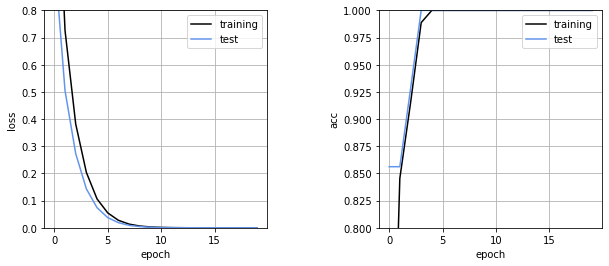

In [89]:
plt.figure(1, figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)
# 학습 및 테스트 데이터에 대한 손실 비교
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='training', color='black')
plt.plot(history.history['val_loss'], label='test',
         color='cornflowerblue')
plt.ylim(0, 0.8)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# 학습 및 테스트 데이터에 대한 정확도 비교
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='training', color='black')
plt.plot(history.history['val_accuracy'],label='test', color='cornflowerblue')
plt.ylim(0.8, 1)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()